# Topological phase diagrams

In [1]:
import kwant
import numpy as np
import numpy.linalg as nla
from types import SimpleNamespace
import tinyarray as ta
import matplotlib.pyplot as plt
from ipywidgets import interact, fixed
import pickle
import os
os.environ['OPENBLAS_NUM_THREADS'] = "1"
os.environ['OMP_NUM_THREADS'] = "1"
try:
    import mkl
    mkl.set_num_threads(1)
except:
    pass

s0 = ta.array([[1,0], [0,1]])
s1 = ta.array([[0,1], [1,0]])
s2 = ta.array([[0, -1j],[1j, 0]])
s3 = ta.array([[1,0], [0, -1]])

In [ ]:
import Mod.MoS2_3bnd as H
import Mod.kp_2bnd as kp2
import Mod.aux as aux

## Topological phase diagram k.p Hamiltonian

In [28]:
# Draw the phase diagram
def draw_diag(k2, mu, Delta=.8e-3):
    vs = np.linspace(0, 0.004, 100)
    k2 = 0.
    mu = 0.
    if kp2.crossings(k2, mu):
        mu1, mu2 = np.sort(kp2.crossings(k2, mu, na=5000))

    # print(crossings(k2, mu))
    fig = plt.figure(figsize=(6, 5))
    plt.plot(vs*1e3, mu1+vs, 'k')
    plt.plot(vs*1e3, mu1-vs, 'k')
    plt.plot(vs*1e3, mu2+vs, 'k')
    plt.plot(vs*1e3, mu2-vs, 'k')

    plt.fill_between(vs*1e3, mu1+vs, mu2+vs, color='r')
    plt.fill_between(vs*1e3, mu1-vs, mu2-vs, color='b')
    plt.fill_between(vs*1e3, mu2-vs, mu1+vs, color='white')

    plt.xlim(xmin=0, xmax=vs.max()*1e3)
    plt.ylim(1.704, 1.712)
    plt.xlabel('$\sqrt{V^2-\Delta^2}$ [meV]')
    plt.ylabel('$\mu$ [eV]')

    plt.savefig('topo.png', dpi=200)
    plt.show()

<IPython.core.display.Javascript object>


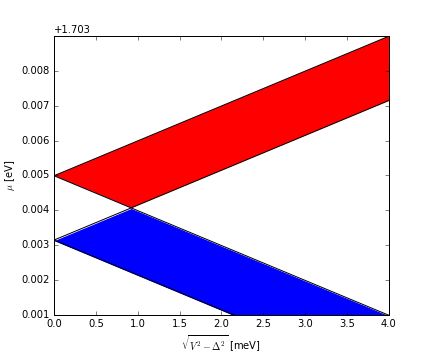

In [45]:
draw_diag(0, 1.704)

## Topological phase k.p

<IPython.core.display.Javascript object>


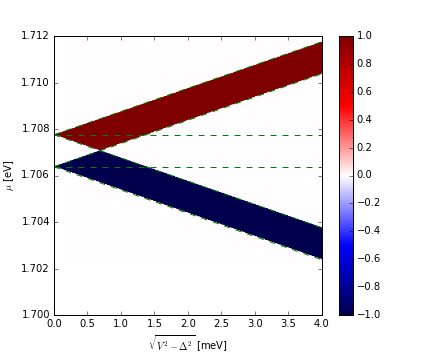

1.70637409821 1.70775259619


In [35]:
mus = np.linspace(1.702, 1.712, 400)
vs = np.linspace(0., 0.004, 400)
k2 = 0.

V, M = np.meshgrid(vs, mus)

Z = kp2.winding(k2, M, V)
fig = plt.figure(figsize=(6, 5))
plt.imshow(Z, extent = [vs.min()*1e3, vs.max()*1e3,  mus.min(), mus.max()], origin='lower', aspect='auto', cmap='seismic')

if kp2.crossings(k2, 0, na=5000):
    mu1, mu2 = np.sort(kp2.crossings(k2, 0, na=5000))    
    print(mu1, mu2)
    plt.plot(vs*1e3, mu1*np.ones_like(vs), 'g--')
    plt.plot(vs*1e3, mu2*np.ones_like(vs), 'g--')
    plt.plot(vs*1e3, mu1+vs, 'g--')
    plt.plot(vs*1e3, mu1-vs, 'g--')
    plt.plot(vs*1e3, mu2+vs, 'g--')
    plt.plot(vs*1e3, mu2-vs, 'g--')

plt.xlabel('$\sqrt{V^2-\Delta^2}$ [meV]')
plt.ylabel('$\mu$ [eV]')
plt.colorbar()
# plt.savefig('topo.png', bbox_inches='tight', dpi=200)
plt.show()

<IPython.core.display.Javascript object>


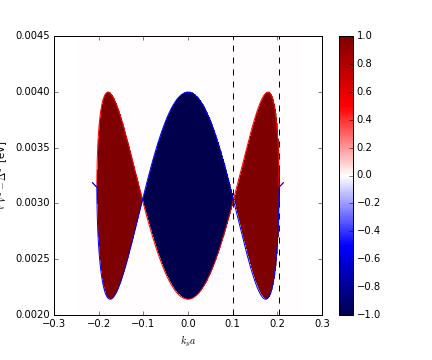

In [44]:
# mus = np.linspace(1.704, 1.71, 400)
mu = 1.704

vs = np.linspace(0.002, 0.0045, 400)
k2s = np.linspace(-0.25, 0.25, 400)

K, V = np.meshgrid(k2s, vs)

"""Winding number
"""
# Z = kp2.winding(K, mu, V)
fig = plt.figure(figsize=(6, 5))

plt.imshow(Z, extent = [k2s.min(), k2s.max(),  vs.min(), vs.max()], origin='lower', aspect='auto', cmap='seismic')
plt.colorbar()

"""Phase boundaries
"""
k2s = np.linspace(-0.01-np.sqrt(-kp2.beta/kp2.A1), 0.01+np.sqrt(-kp2.beta/kp2.A1), 3000)
mu = 1.704
vs1 = []
vs2 = []
for k2 in k2s:
    coeff = [kp2.A2, kp2.A1, -3*k2**2*kp2.A2, kp2.A1*k2**2+kp2.beta]
    roots = np.sort(np.roots(coeff))
    k1s = roots[np.abs(roots) < 1]

    vs1.append(kp2.t*(k1s[0]**2+k2**2)-mu+kp2.f0)
    vs2.append(kp2.t*(k1s[1]**2+k2**2)-mu+kp2.f0)

    
vs1 = np.asarray(vs1)
vs2 = np.asarray(vs2)

plt.plot(k2s, np.real(vs1), 'r-')
plt.plot(k2s, np.real(vs2), 'b-')

"""Bubble limits
"""
plt.vlines(x = 0.5*np.sqrt(np.abs(kp2.f6/kp2.A1)), ymin=vs.min(), ymax=vs.max(), linestyles='dashed')
plt.vlines(x = np.sqrt(np.abs(kp2.f6/kp2.A1)), ymin=vs.min(), ymax=vs.max(), linestyles='dashed')

plt.xlabel('$k_ya$')
plt.ylabel('$\sqrt{V^2-\Delta^2}$ [eV]')
plt.savefig('topo.png', bbox_inches='tight', dpi=200)
plt.show()

## Topological phase diagram for 3-band model

In [ ]:
p = SimpleNamespace(B=0., theta=0., lam=.073, mu=0., bso=0.00035, delta = .8e-3, edge=[-1, 2])

### Armchair edges

Optimized routine for computing phase diagram in armchair edges.

In [ ]:
def scan_wind_ky(p, beta, mus, sqvd):
    """Scan winding number when varying mu and sqrt(V^2-D^2) at fixed ky
    """
    vs = np.sqrt(sqvd**2+p.delta**2)
    V, M = np.meshgrid(vs, mus)
    proc = lview.map_async(lambda par: H.winding(p, beta=beta, mu=par[1], B=par[0]),
        zip(V.ravel(), M.ravel()))
    proc.wait_interactive(interval=2)
    return np.asarray(proc.get()).reshape(M.shape)

def scan_wind_mu(p, betas, mu, sqvd):
    """Scan winding number when 
    """
    vs = np.sqrt(sqvd**2+p.delta**2)
    K, V = np.meshgrid(betas, vs)
    proc = lview.map_async(lambda par: H.winding(p, beta=par[0], mu=mu, B=par[1]),
        zip(K.ravel(), V.ravel()))
    proc.wait_interactive(interval=2)
    return np.asarray(proc.get()).reshape(V.shape)

Diagram at fixed ky

In [ ]:
%%time
muMin = 1.704
muMax = 1.712
vMin = 0.
vMax = 0.004
b = 0

mus = np.linspace(muMin, muMax, 200)
sqvd = np.linspace(vMin, vMax, 200)

Z = scan_wind_ky(p, b, mus, sqvd)

file = 'wind_3bnd_'+'beta_'+str(b)+'.p'
pickle.dump((Z, p, b, mus, sqvd), open(file, 'wb'))

In [ ]:
%matplotlib notebook
Z, p, beta, mus, sqvd = pickle.load(open(file, 'rb'))

fig = plt.figure(figsize=(5, 5))

plt.imshow(Z, extent = [sqvd.min()*1e3, sqvd.max()*1e3, mus.min(), mus.max()], origin='lower', aspect='auto', cmap='seismic')
plt.colorbar()
plt.xlabel('$\sqrt{V^2-\Delta^2}$ [meV]')
plt.ylabel('$\mu$ [eV]')

# crossings
print(beta)
mu1, mu2 = H.crossings(p, beta)
print(mu1, mu2)

plt.plot(sqvd*1e3, mu1+sqvd, 'green', ls='dashed')
plt.plot(sqvd*1e3, mu1-sqvd, 'green', ls='dashed')
plt.plot(sqvd*1e3, mu2+sqvd, 'green', ls='dashed')
plt.plot(sqvd*1e3, mu2-sqvd, 'green', ls='dashed')

plt.hlines(y=mu1, xmin=sqvd.min()*1e3, xmax=sqvd.max()*1e3, linestyles='dashed', linewidth=1., color='g')
plt.hlines(y=mu2, xmin=sqvd.min()*1e3, xmax=sqvd.max()*1e3, linestyles='dashed', linewidth=1., color='g')

plt.ylim(mus.min(), mus.max())
# plt.savefig('wind_ky.png', bbox_inches='tight', dpi=200)
plt.show()

Diagram at fixed mu

In [ ]:
sqvd = np.linspace(0., 0.0015, 300)
betas = np.linspace(-0.2, 0.2, 300)
mu = 1.709

Z = scan_wind_mu(p, betas, mu, sqvd)
file = 'wind_3bnd_'+'mu_'+str(mu)+'.p'

In [ ]:
%matplotlib notebook
Z, p, beta, mus, sqvd = pickle.load(open(file, 'rb'))

fig = plt.figure(figsize=(5, 5))

plt.imshow(Z, extent = [sqvd.min()*1e3, sqvd.max()*1e3, mus.min(), mus.max()], origin='lower', aspect='auto', cmap='seismic')
plt.colorbar()
plt.xlabel('$\sqrt{V^2-\Delta^2}$ [meV]')
plt.ylabel('$\mu$ [eV]')

# crossings
print(beta)
mu1, mu2 = H.crossings(p, beta)
print(mu1, mu2)

plt.plot(sqvd*1e3, mu1+sqvd, 'green', ls='dashed')
plt.plot(sqvd*1e3, mu1-sqvd, 'green', ls='dashed')
plt.plot(sqvd*1e3, mu2+sqvd, 'green', ls='dashed')
plt.plot(sqvd*1e3, mu2-sqvd, 'green', ls='dashed')

plt.hlines(y=mu1, xmin=sqvd.min()*1e3, xmax=sqvd.max()*1e3, linestyles='dashed', linewidth=1., color='g')
plt.hlines(y=mu2, xmin=sqvd.min()*1e3, xmax=sqvd.max()*1e3, linestyles='dashed', linewidth=1., color='g')

plt.ylim(mus.min(), mus.max())
# plt.savefig('wind_ky.png', bbox_inches='tight', dpi=200)
plt.show()

### Arbitrary edges

In [ ]:
def scan_W_any_kpar(p, kpar, mus, sqvd, na=300):
    """Scan winding number at fixed k parallel [varying mu and sqrt(V^2-D^2)]
    """
    vs = np.sqrt(sqvd**2+p.delta**2)
    V, M = np.meshgrid(vs, mus)
    proc = lview.map_async(lambda par: H.winding_adaptative(p, kpar=kpar, mu=par[1], B=par[0], na=na),
        zip(V.ravel(), M.ravel()))
    proc.wait_interactive(interval=2)
    return np.asarray(proc.get()).reshape(M.shape)

def scan_W_any_mu(p, kpars, mu, sqvd, na = 300):
    """Scan winding number when at fixed mu [varying kpar and sqrt(V^2-D^2)]
    """
    vs = np.sqrt(sqvd**2+p.delta**2)
    K, V = np.meshgrid(kpars, vs)
        
    proc = lview.map_async(lambda par: H.winding_adaptative(p, kpar=par[0], mu=mu, B=par[1], na=na),
        zip(K.ravel(), V.ravel()))

    proc.wait_interactive(interval=2)
    return np.asarray(proc.get()).reshape(V.shape)

Diagram at fixed kpar

In [ ]:
mus = np.linspace(1.704, 1.712, 60)
sqvd = np.linspace(0, 0.002, 60)
kpar = 0
p.edge = (-8, 17)
Z = scan_W_any_kpar(p, kpar, mus, sqvd, na = 1000)

file = 'W3_kpar_'+str(kpar)+'_'+str(p.edge[0])+'_'+str(p.edge[1])+'.p'
pickle.dump((Z, p, kpar, mus, sqvd), open(file, 'wb'))

In [ ]:
%matplotlib notebook

print('BZ is larger by: ', np.sqrt(p.edge[0]**2+p.edge[1]**2+p.edge[0]*p.edge[1])/np.sqrt(3))

Z, p, kpar, mus, sqvd = pickle.load(open(file,'rb'))
fig = plt.figure(figsize=(5, 5))

plt.imshow(Z, extent = [sqvd.min()*1e3, sqvd.max()*1e3, mus.min(), mus.max()],
    origin='lower', aspect='auto', cmap='seismic')

plt.colorbar()
plt.xlabel('$\sqrt{V^2-\Delta^2}$ [meV]')
plt.ylabel('$\mu$ [eV]')

# crossings
print(kpar)

x1, mu1, x2, mu2 = cross_points(p, kpar, k_val=4*np.pi/3., plot=False)
plt.plot(sqvd*1e3, mu1+sqvd, 'green', ls='dashed')
plt.plot(sqvd*1e3, mu1-sqvd, 'green', ls='dashed')
plt.plot(sqvd*1e3, mu2+sqvd, 'green', ls='dashed')
plt.plot(sqvd*1e3, mu2-sqvd, 'green', ls='dashed')

plt.ylim(mus.min(), mus.max())
# plt.savefig('wind_ky.png', bbox_inches='tight', dpi=200)
plt.show()

Diagram at fixed mu

In [ ]:
sqvd = np.linspace(0.0006, 0.002, 100)
kpar_lim = np.pi/np.sqrt(p.edge[0]**2+p.edge[1]**2+p.edge[0]*p.edge[1])
kpars = np.linspace(-kpar_lim, kpar_lim, 100)

mu = 1.707
p.edge = [-8, 17]

Z = scan_W_any_mu(p, kpars, mu, sqvd, na = 1000)
file = 'W3_mu_'+str(mu)+'_'+str(p.edge[0])+'_'+str(p.edge[1])+'.p'
pickle.dump((Z, p, kpars, mu, sqvd), open(file,'wb'))

In [ ]:
Z, p, kpars, mus, sqvd = pickle.load(open(file,'rb'))

fig = plt.figure(figsize=(5, 5))

plt.imshow(Z, extent = [kpars.min(), kpars.max(), sqvd.min()*1e3, sqvd.max()*1e3],
        origin='lower', aspect='auto', cmap='seismic',
        norm=aux.MidpointNormalize(vmin=Z.min(), vmax=Z.max(), midpoint=0))

plt.colorbar()
plt.ylabel('$\k_\parallel a$')
plt.ylabel('$\sqrt{V^2-\Delta^2}$ [meV]')
plt.title('$\mu = '+str(mu)+'$ eV; edge=(-8, 17)')
plt.savefig('topo.png', dpi=200, bbox_inches='tight')
plt.show()

### Graphic calculation of winding number

In [ ]:
p = SimpleNamespace(B=0., theta=0., lam=.073, mu=0., bso=0.00035, delta = .8e-3, edge=[-1, 2])
m = -5
n = 1-2*m
p.edge = [m, n]
print(p.edge)
print(np.rad2deg(aux.ang(p.edge)))
print(np.sqrt(p.edge[0]**2+p.edge[1]**2+p.edge[0]*p.edge[1])/np.sqrt(3))
kpar = 0.

# cross = np.asarray((1.8414, 1.8321, 1.8346, 1.8366, 1.8311, 1.8427))
# cross = np.asarray((1.8375, 1.8360, 1.8427, 1.8322))

dR, dL = H.cross_data(p, kpar, n_val=5)

In [ ]:
mus = np.linspace(1.704, 1.712, 400)
sqvd = np.linspace(0, 0.001, 400)

In [ ]:
Z = winding_mesh(sqvd, mus, dR, dL)

fig = plt.figure(figsize=(5, 5))

plt.imshow(Z, extent = [sqvd.min()*1e3, sqvd.max()*1e3, mus.min(), mus.max()],
           origin='lower', aspect='auto', cmap='seismic',
           norm=aux.MidpointNormalize(midpoint=0, vmin=Z.min(), vmax=Z.max()))

plt.xlabel('$\sqrt{V^2-\Delta^2}$ [meV]')
plt.ylabel('$\mu$ [eV]')
plt.colorbar()
# plt.savefig('angle.png', bbox_inches='tight', dpi=200)
plt.show()